In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import shutil

In [5]:
# Đưa model vào GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
print(os.path.exists(r'train_augment'))

True


### Random choose 350 images from each class to train -> avoid Bias


In [7]:
# list_dir = os.listdir('CNN_BASICS\\original_images')
# for dir in list_dir:
#     if dir== 'trash': continue
#     files=os.listdir('CNN_BASICS\\original_images\\'+ dir)
#     train_path, test_path=train_test_split(files, train_size=350/len(files))
#     for path in train_path:
#         shutil.copy(os.path.join('CNN_BASICS\\original_images', dir, path), os.path.join('CNN_BASICS\\train', dir))
#     for path in test_path:
#         shutil.copy(os.path.join('CNN_BASICS\\original_images', dir, path), os.path.join('CNN_BASICS\\test', dir))


In [8]:
# Define transforms for images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor()   #has done normalizing in range [0, ...1]
])

In [9]:
train_set= dsets.ImageFolder(root=r'train_augment', transform=transform)
valid_set= dsets.ImageFolder(root=r'val_augment', transform=transform)

In [10]:
len(train_set)

6000

In [11]:
len(valid_set)

1200

In [12]:
batch_size = 32
n_iters = 10000  # number of times running 1 batch (in summation train:s 3000 batches)
num_epochs = n_iters / (len(train_set) / batch_size) # run whole data n times
num_epochs = int(num_epochs)

# Divide data into batch to iterate over
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_set,
                                          batch_size=batch_size,
                                          shuffle=True)

In [13]:
# Info of each batch
# samples x channels (1 or 3 RGB) x height x width
for inputs, labels in train_loader:
    print("Inputs shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    break  # Inspect only the first batch


Inputs shape: torch.Size([32, 1, 32, 32])
Labels shape: torch.Size([32])


### Step 3: Theory

#### Output Formula for Convolution
- $ O = \frac {W - K + 2P}{S} + 1$
    - $O$: output height/length
    - $W$: input height/length
    - $K$: **filter size (kernel size) = 5**
    - $P$: **same padding (non-zero)**
        - $P = \frac{K - 1}{2}  = \frac{5 - 1}{2} = 2$
    - $S$: **stride = 1**
    
#### Output Formula for Pooling/Downsampling
- $ O = \frac {W - K}{S} + 1$
    - W: input height/width
    - K: **filter size = 2**
    - S: **stride size = filter size**, PyTorch defaults the stride to kernel filter size
        - If using PyTorch default stride, this will result in the formula $ O = \frac {W}{K}$
    
<img src="./images/cnn10-2n.png" alt="deeplearningwizard" style="width: 900px;"/>

##Code

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
                            #color channels # 16 kernel types
                                            # kernels are initialized randomly and are adjusted through backpropagation.
                                            # choosing number of kernels depends on experience
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        # # # Convolution 4
        # self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # self.relu4 = nn.ReLU()

        # # # Max pool 4
        # self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout - dense layer)
        self.fc1 = nn.Linear(64 * 4 * 4, 4)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max pool 2
        out = self.maxpool2(out)

        # Convolution 3
        out = self.cnn3(out)
        out = self.relu3(out)

        # Max pool 3
        out = self.maxpool3(out)

        # # # Convolution 3
        # out = self.cnn4(out)
        # out = self.relu4(out)

        # # # Max pool 3
        # out = self.maxpool4(out)

        # Resize
        # Original size: (100, 32, 8, 8)
        # New out size: (100, 32*8*8)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        # Put 50 output samples into linear to calc softmax and cross entropy loss for each output sample
        out = self.fc1(out)

        return out

In [15]:
model1= CNNModel()
criterion = nn.CrossEntropyLoss()

learning_rate = 0.02
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)

In [16]:
model1.to(device)


CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=4, bias=True)
)

In [17]:
accuracy_history=[]
iteration_history=[]
loss_history=[]

In [18]:
'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        #######################
        #  USE GPU FOR MODEL  #
        #######################

        # Feed input to GPU
        images = images.requires_grad_().to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model1(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in valid_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.requires_grad_().to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model1(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            
            accuracy_history.append(accuracy)
            iteration_history.append(iter)
            loss_history.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.2777040004730225. Accuracy: 37.83333206176758
Iteration: 1000. Loss: 0.9797532558441162. Accuracy: 47.83333206176758
Iteration: 1500. Loss: 0.8348695635795593. Accuracy: 52.0
Iteration: 2000. Loss: 0.48306527733802795. Accuracy: 59.16666793823242
Iteration: 2500. Loss: 0.661252498626709. Accuracy: 58.91666793823242
Iteration: 3000. Loss: 0.5385705232620239. Accuracy: 63.0
Iteration: 3500. Loss: 0.5203022956848145. Accuracy: 62.08333206176758
Iteration: 4000. Loss: 0.5281258821487427. Accuracy: 63.58333206176758
Iteration: 4500. Loss: 0.32323363423347473. Accuracy: 64.66666412353516
Iteration: 5000. Loss: 0.539762556552887. Accuracy: 62.91666793823242
Iteration: 5500. Loss: 0.3754739761352539. Accuracy: 65.33333587646484
Iteration: 6000. Loss: 0.3337562084197998. Accuracy: 66.58333587646484
Iteration: 6500. Loss: 0.331022709608078. Accuracy: 63.91666793823242
Iteration: 7000. Loss: 0.23330628871917725. Accuracy: 66.33333587646484
Iteration: 7500. Loss: 0.18986824

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

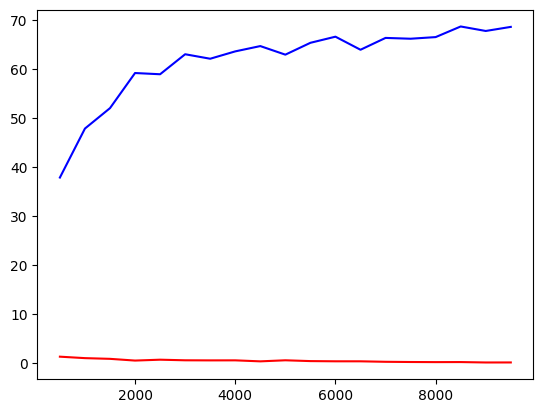

In [20]:
plt.plot(iteration_history, accuracy_history, color='blue')
plt.plot(iteration_history, loss_history, color='red')

<Axes: >

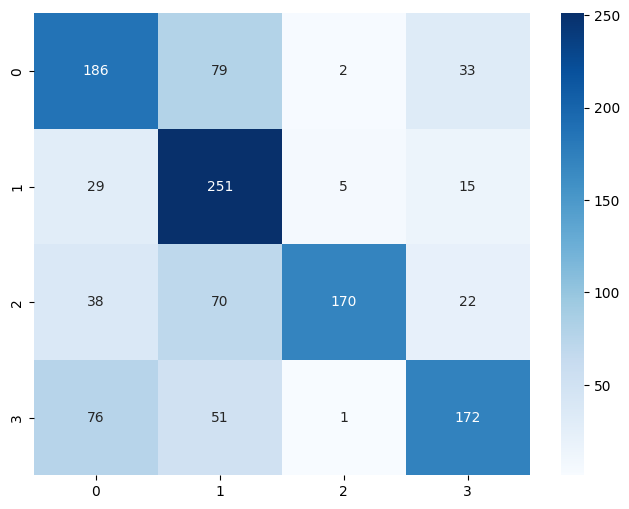

In [21]:
# Step 2: Evaluate Model and Get Predictions
model1.eval()  # Set model to evaluation mode

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Step 3: Compute Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [ ]:
# Hook để lấy đặc trưng và gradient
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(),
])

img_path = 'val\Đùi gà Baby (cắt ngắn)\DG003.jpg'  # Thay bằng đường dẫn ảnh của bạn
img = Image.open(img_path).convert('RGB')
img_tensor = preprocess(img).unsqueeze(0)

features = []
gradients = []

def get_features(module, input, output):
    features.append(output)

def get_gradients(module, grad_input, grad_output):
    gradients.append(grad_output[0])

last_conv_layer = model1.layer4
last_conv_layer.register_forward_hook(get_features)
last_conv_layer.register_backward_hook(get_gradients)

# Dự đoán
output = model1(img_tensor)
class_idx = torch.argmax(output, dim=1).item()

# Tính gradient
model1.zero_grad()
output[0, class_idx].backward()

# Tạo heatmap
feature = features[0][0]
gradient = gradients[0][0]
pooled_grads = torch.mean(gradient, dim=[1, 2])

heatmap = torch.zeros(feature.shape[1:], dtype=torch.float32)
for i in range(feature.shape[0]):
    heatmap += feature[i] * pooled_grads[i]

heatmap = torch.relu(heatmap)
heatmap = heatmap / torch.max(heatmap)
heatmap = heatmap.detach().cpu().numpy()

# Trực quan hóa
img_np = np.array(img)
heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_img = heatmap_colored * 0.4 + img_np * 0.6

plt.imshow(superimposed_img.astype('uint8'))
plt.axis('off')
plt.show()